# EDA: VADER Baseline on Sample Financial Texts

## Imports & Paths

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.preprocess.text_cleaner import clean_text
from src.models.sentiment import score_vader

RAW = Path("../data/raw/sample_texts.csv")
OUT = Path("../data/processed/sample_texts_scored.csv")

## Load & Clean

In [13]:
df = pd.read_csv(RAW, parse_dates=["timestamp"])
df["text_clean"] = df["text"].map(clean_text)
df.head()

,timestamp,ticker,source,text,text_clean
0,2025-08-22 09:15:00+00:00,AAPL,tweet,Apple’s new iPhone looks insane — bullish into...,apple s new iphone looks insane bullish into e...
1,2025-08-22 09:18:00+00:00,TSLA,news,Tesla shares rise after production update beat...,tesla shares rise after production update beat...
2,2025-08-22 09:21:00+00:00,NVDA,reddit,"NVDA earnings were fire, but valuation still s...",nvda earnings were fire but valuation still sc...
3,2025-08-22 09:30:00+00:00,AAPL,news,Analyst cuts estimates; warns of supply chain ...,analyst cuts estimates warns of supply chain r...
4,2025-08-22 09:45:00+00:00,TSLA,tweet,bro this dip was a gift,bro this dip was a gift


## Score with VADER

In [15]:
# keep both columns with distinct names
df = pd.read_csv(RAW, parse_dates=["timestamp"])
df["text_clean"] = df["text"].map(clean_text)

# score on the cleaned text
scored = score_vader(df, text_col="text_clean")
scored[["ticker","source","text","text_clean","neg","neu","pos","compound"]].head()

,ticker,source,text,text_clean,neg,neu,pos,compound
0,AAPL,tweet,Apple’s new iPhone looks insane — bullish into...,apple s new iphone looks insane bullish into e...,0.278,0.722,0.000,-0.4019
1,TSLA,news,Tesla shares rise after production update beat...,tesla shares rise after production update beat...,0.000,0.761,0.239,0.2960
2,NVDA,reddit,"NVDA earnings were fire, but valuation still s...",nvda earnings were fire but valuation still sc...,0.375,0.625,0.000,-0.5859
3,AAPL,news,Analyst cuts estimates; warns of supply chain ...,analyst cuts estimates warns of supply chain r...,0.449,0.551,0.000,-0.5719
4,TSLA,tweet,bro this dip was a gift,bro this dip was a gift,0.000,0.580,0.420,0.4404


## Basic aggregates

In [16]:
# sentiment by ticker
agg_ticker = scored.groupby("ticker")["compound"].mean().sort_values(ascending=False)
display(agg_ticker)

# resample by 15 minutes
scored = scored.sort_values("timestamp")
sent_time = (
    scored.set_index("timestamp")
          .groupby("ticker")["compound"]
          .resample("15min")
          .mean()
          .reset_index()
)
sent_time.head()

ticker
TSLA    0.3682
AAPL   -0.4869
NVDA   -0.5859
Name: compound, dtype: float64

,ticker,timestamp,compound
0,AAPL,2025-08-22 09:15:00+00:00,-0.4019
1,AAPL,2025-08-22 09:30:00+00:00,-0.5719
2,NVDA,2025-08-22 09:15:00+00:00,-0.5859
3,TSLA,2025-08-22 09:15:00+00:00,0.2960
4,TSLA,2025-08-22 09:30:00+00:00,NaN


## Plots

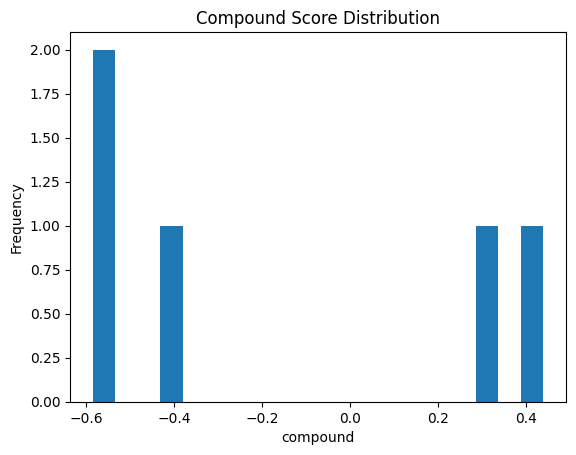

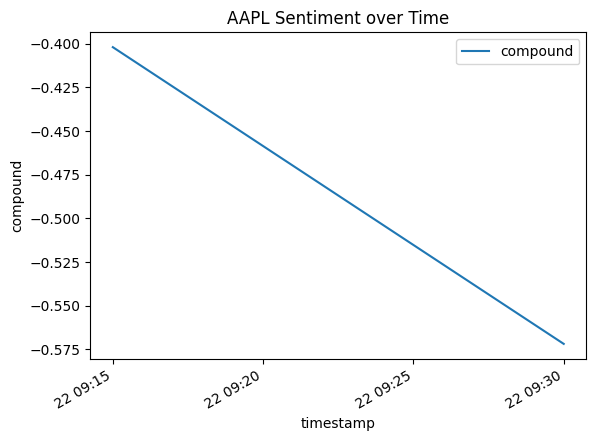

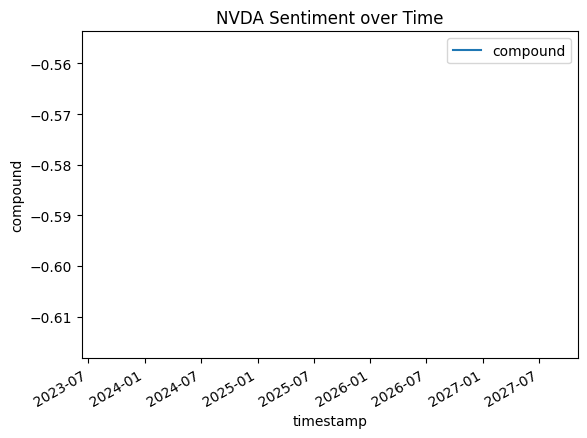

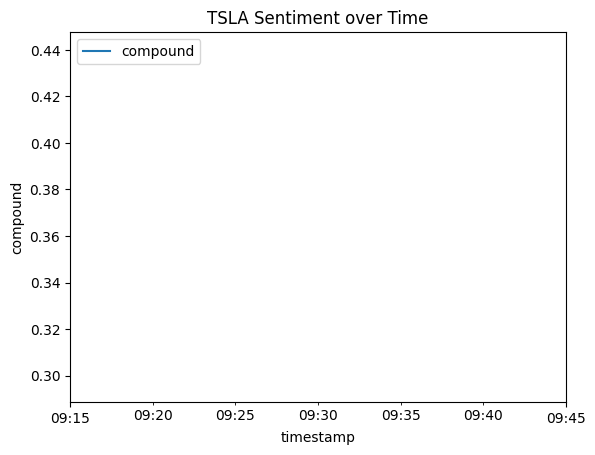

In [17]:
# compound distribution
scored["compound"].plot(kind="hist", bins=20, title="Compound Score Distribution")
plt.xlabel("compound")
plt.show()

# time series by ticker
for t in sent_time["ticker"].unique():
    tmp = sent_time[sent_time["ticker"] == t]
    tmp.plot(x="timestamp", y="compound", title=f"{t} Sentiment over Time")
    plt.ylabel("compound")
    plt.show()

## Save Processed

In [18]:
scored.to_csv(OUT, index=False)
OUT

PosixPath('../data/processed/sample_texts_scored.csv')